### mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir(current_path)


interval = '30m'
interval = '1m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 OMGUSDT.xlsx', '2021-05-17 BTCUSDT.xlsx', '2021-05-17 ETHUSDT.xlsx', '2021-05-17 BCHUSDT.xlsx', '2021-05-17 XRPUSDT.xlsx', '2021-05-17 EOSUSDT.xlsx', '2021-05-17 LTCUSDT.xlsx', '2021-05-17 ETCUSDT.xlsx', '2021-05-17 LINKUSDT.xlsx', '2021-05-17 XLMUSDT.xlsx', '2021-05-17 ADAUSDT.xlsx', '2021-05-17 XMRUSDT.xlsx', '2021-05-17 SXPUSDT.xlsx', '2021-05-17 KAVAUSDT.xlsx', '2021-05-17 BANDUSDT.xlsx', '2021-05-17 DASHUSDT.xlsx', '2021-05-17 ZECUSDT.xlsx', '2021-05-17 XTZUSDT.xlsx', '2021-05-17 BNBUSDT.xlsx', '2021-05-17 ATOMUSDT.xlsx', '2021-05-17 ONTUSDT.xlsx', '2021-05-17 IOTAUSDT.xlsx', '2021-05-17 BATUSDT.xlsx', '2021-05-17 NEOUSDT.xlsx', '2021-05-17 QTUMUSDT.xlsx', '2021-05-17 WAVESUSDT.xlsx', '2021-05-17 MKRUSDT.xlsx', '2021-05-17 SNXUSDT.xlsx', '2021-05-17 DOTUSDT.xlsx', '2021-05-17 THETAUSDT.xlsx', '2021-05-17 ALGOUSDT.xlsx', '2021-05-17 KNCUSDT.xlsx', '2021-05-17 ZRXUSDT.xlsx', '2021-05-17 COMPUSDT.xlsx']


### setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### weather data

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

### basic fishing (not concerned about rapid descending)

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 7)
lvrg_list = range(6, 10)
lvrg_list = range(1, 2)
lvrg_list = range(5, 6)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:
      
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        #       long      #
        pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(ohlcv['low'] < long_ep, pr, 1)
      
        lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       short       #
        # s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        ap = np.cumprod(pr)[-1]
        if ap >= best_ap:
          best_ep = long_ep
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      # plt.figure(figsize=(10, 4))
      plt.figure(figsize=(6, 4))
      # plt.subplot(121)
      plt.plot(np.cumprod(best_pr))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))

      
      #     avoid dropping    #      
      # ema = ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
      # # avoid_pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), test_pr, 1)

      # avoid_pr = np.where(ema.shift(1) > ema.shift(2), best_pr, 1)

      # # ma = ohlcv['close'].rolling(120).mean()
      # # avoid_pr = np.where(ma.shift(1) > ma.shift(2), best_pr, 1)

      # avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

      
      # plt.subplot(122)
      # plt.plot(np.cumprod(avoid_pr))
      # plt.title("%s\navoid_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, avoid_wr, np.cumprod(avoid_pr)[-1], best_tp, lvrg))

      plt.show()








### check data

In [ ]:
df = ohlcv
print(df.head())

# sar = lucid_sar(ohlcv)
# ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
# ema1, ema2, ema3 = ema_ribbon(ohlcv)
# senkou1, senkou2 = ichimoku(ohlcv)
# cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

# _, _, bbw = bb_width(ohlcv, 20, 2) 

df['fish60'] = fisher(ohlcv, 60)
df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
# rsi_ = rsi(ohlcv)
df['macd_hist'] = macd(ohlcv)

df.describe().transpose()

                           open    high     low   close   volume
2021-05-07 00:00:59.999  40.801  40.881  40.769  40.862  11567.2
2021-05-07 00:01:59.999  40.862  40.921  40.573  40.644  67078.2
2021-05-07 00:02:59.999  40.641  40.680  40.498  40.500  37598.6
2021-05-07 00:03:59.999  40.523  40.560  40.462  40.477  16816.8
2021-05-07 00:04:59.999  40.473  40.605  40.427  40.511  31256.4


,count,mean,std,min,25%,50%,75%,max
open,15840.0,40.822113,2.827351,32.432000,39.356000,40.167000,41.580000,49.766000
high,15840.0,40.893931,2.835840,32.801000,39.410750,40.228000,41.662500,49.855000
low,15840.0,40.749432,2.819406,32.000000,39.300000,40.106000,41.506500,49.644000
close,15840.0,40.821896,2.827420,32.421000,39.357000,40.165500,41.580250,49.765000
volume,15840.0,19079.415593,24425.041499,444.200000,6430.150000,11510.600000,21782.575000,448892.500000
fish60,15781.0,0.135282,2.210354,-7.589308,-1.349973,0.074315,1.536080,7.600397
trix,15835.0,0.000012,0.007698,-0.084258,-0.003635,-0.000092,0.003578,0.066075
macd_hist,15816.0,0.000012,0.039855,-0.425686,-0.019201,-0.000613,0.018773,0.284256


### remove nan data

In [ ]:
print((np.isnan(df.values)))
print(np.sum(np.isnan(df.values), axis=0))

max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
print(max_nan)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[ 0  0  0  0  0 59  5 24]
59


In [ ]:
df = df.iloc[max_nan:]

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,15781.0,40.823228,2.832533,32.432000,39.350000,40.162000,41.588000,49.766000
high,15781.0,40.895129,2.841033,32.801000,39.406000,40.223000,41.668000,49.855000
low,15781.0,40.750509,2.824574,32.000000,39.298000,40.103000,41.516000,49.644000
close,15781.0,40.823060,2.832595,32.421000,39.350000,40.161000,41.588000,49.765000
volume,15781.0,19079.274324,24438.303627,444.200000,6421.500000,11511.000000,21785.500000,448892.500000
fish60,15781.0,0.135282,2.210354,-7.589308,-1.349973,0.074315,1.536080,7.600397
trix,15781.0,0.000010,0.007700,-0.084258,-0.003630,-0.000092,0.003567,0.066075
macd_hist,15781.0,0.000049,0.039878,-0.425686,-0.019163,-0.000575,0.018814,0.284256


#### time survey

In [ ]:
timestamp_s = df.index.map(datetime.datetime.timestamp)
# timestamp_s = date_time.map(datetime.datetime.timestamp)
# print(timestamp_s)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

print(df.head())

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### target column

In [ ]:
target = "close"
target = "macd_hist"
# target = 'T (degC)'


#### fft

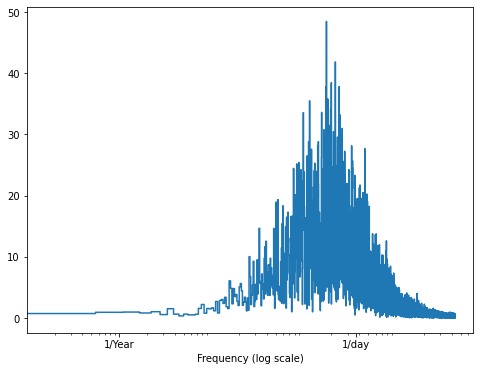

In [ ]:
fft = tf.signal.rfft(df[target])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[target])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### data proc

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print("len(test_df) :", len(test_df))

num_features = df.shape[1]
print("num_features :", num_features)
print("column_indices :", column_indices)

len(test_df) : 1579
num_features : 12
column_indices : {'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4, 'fish60': 5, 'trix': 6, 'macd_hist': 7, 'Day sin': 8, 'Day cos': 9, 'Year sin': 10, 'Year cos': 11}


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

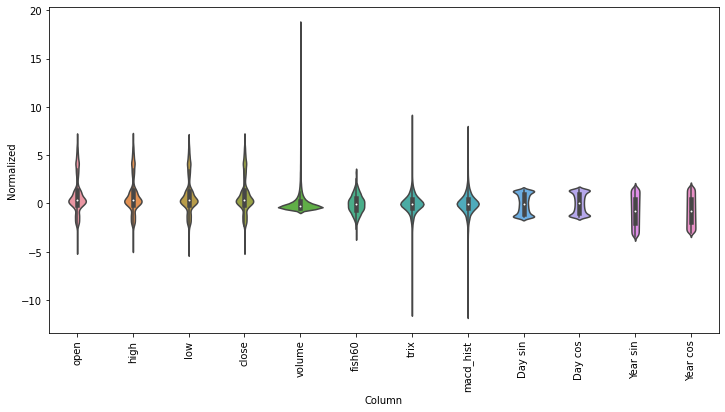

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### windowing

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[target])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[target])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 12)
Inputs shape: (3, 6, 12)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

### plot

In [ ]:
def plot(self, model=None, plot_col=target, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
w2.plot()

In [ ]:
w2.plot(plot_col='volume')

In [ ]:
w2.plot(plot_col='macd_hist')

### create tf.data.Datasets

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      # shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    # result = next(iter(self.train))
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 12)
Labels shape (batch, time, features): (32, 1, 1)


### models

#### baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

80/80 [==============================] - 1s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0324


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

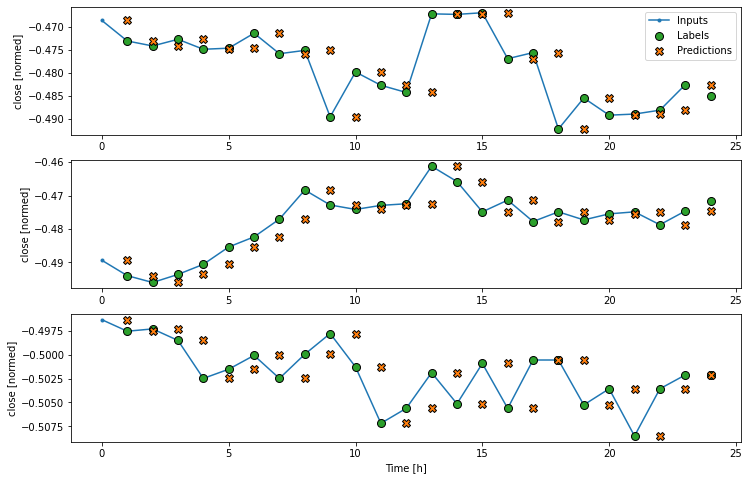

In [ ]:
wide_window.plot(baseline)

### multi step

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['macd_hist']

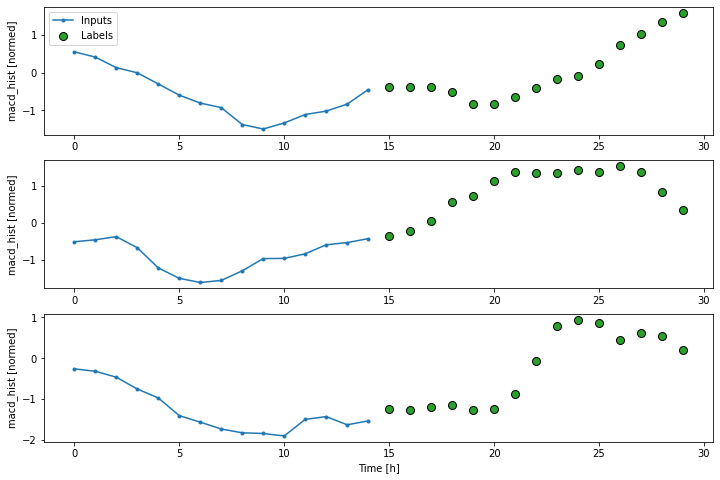

In [ ]:
OUT_STEPS = 60
# OUT_STEPS = 24
OUT_STEPS = 15

multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=[target]
                               )

# multi_window.plot()
multi_window.plot(plot_col=target, max_subplots=3)
multi_window

In [ ]:
# MAX_EPOCHS = 100
MAX_EPOCHS = 50
# MAX_EPOCHS = 20

patience = MAX_EPOCHS // 5
# patience = 2

def compile_and_fit(model, window, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=1e-6),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
multi_val_performance = {}
multi_performance = {}

#### dense

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# model_name = 'multi_step_weather_dense_%s_%s.h5' % (OUT_STEPS, OUT_STEPS)


In [ ]:
history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()

In [ ]:
# model = tf.keras.models.load_model(ckpt_path + model_name)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=1)

49/49 [==============================] - 0s 5ms/step - loss: 1.4092 - mean_absolute_error: 0.8812


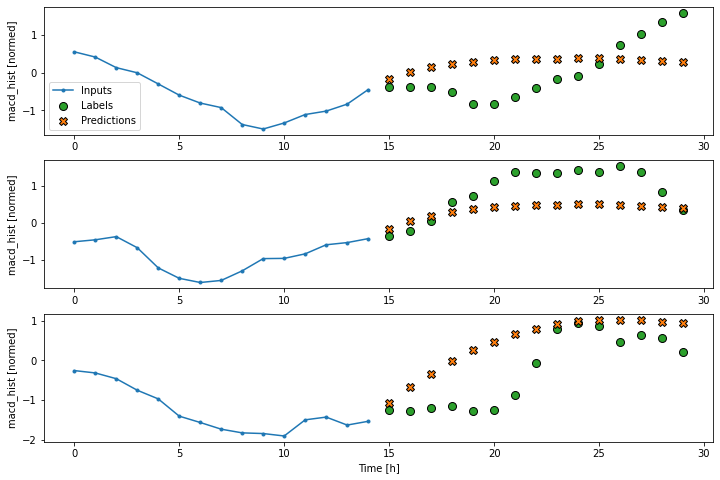

In [ ]:
multi_window.plot(multi_dense_model)

##### denorm

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_dense_model(x).shape :", multi_dense_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_dense_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

#### lstm

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()


In [ ]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

437/437 [==============================] - 3s 6ms/step - loss: 0.0922 - mean_absolute_error: 0.2293


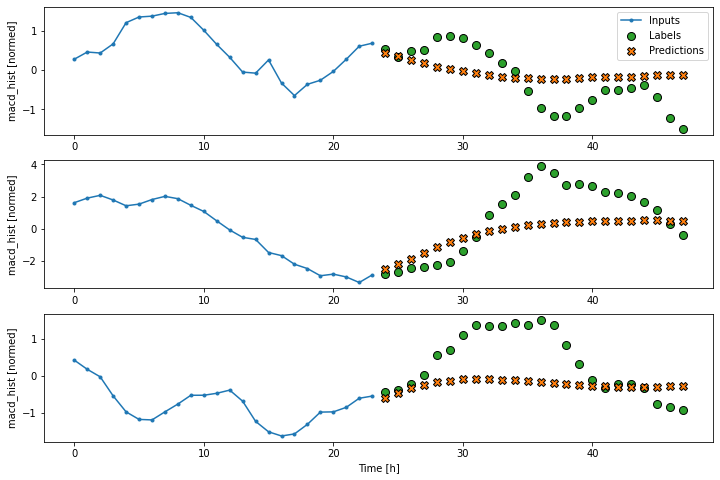

In [ ]:
multi_window.plot(multi_lstm_model, max_subplots=3)

##### denorm

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


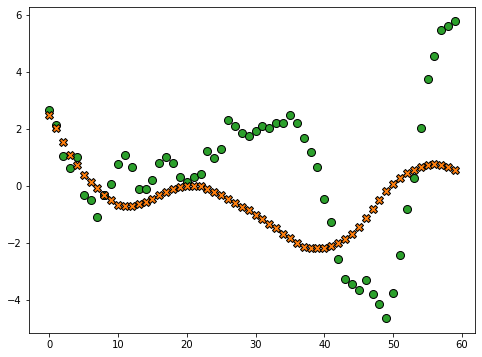

label.shape : (60,)
pred.shape : (60,)


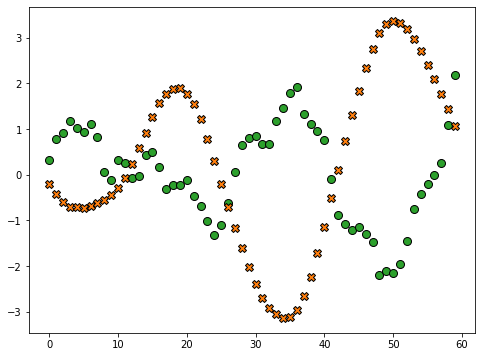

label.shape : (60,)
pred.shape : (60,)


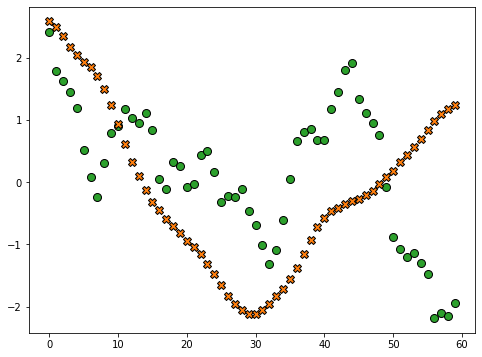

label.shape : (60,)
pred.shape : (60,)


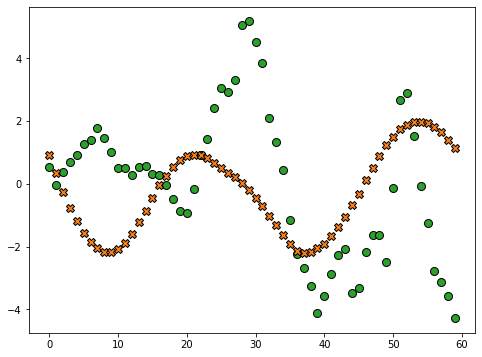

label.shape : (60,)
pred.shape : (60,)


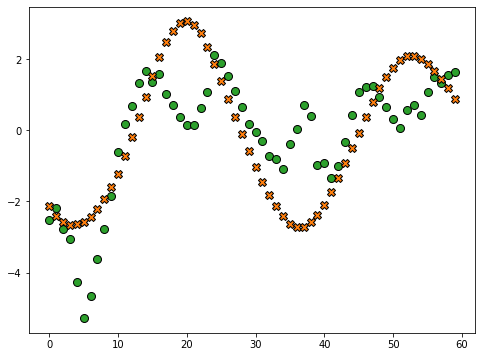

label.shape : (60,)
pred.shape : (60,)


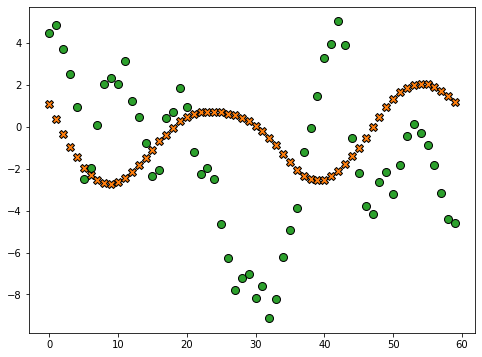

label.shape : (60,)
pred.shape : (60,)


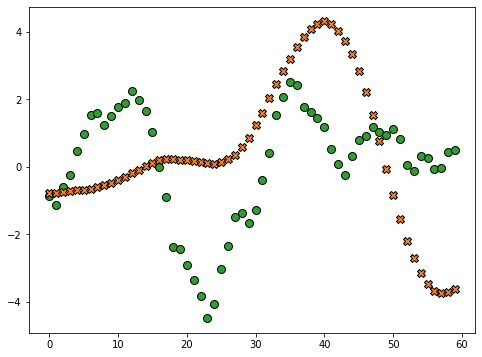

label.shape : (60,)
pred.shape : (60,)


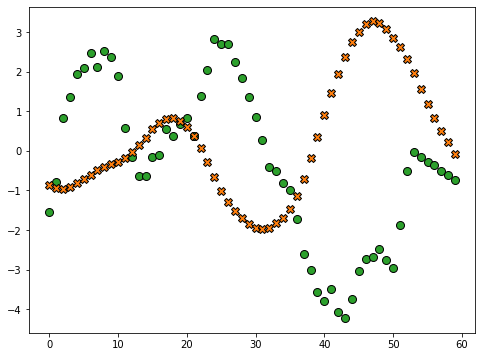

label.shape : (60,)
pred.shape : (60,)


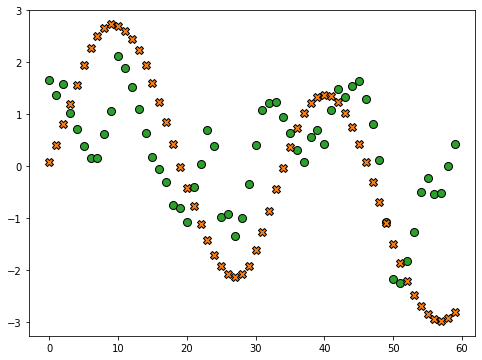

label.shape : (60,)
pred.shape : (60,)


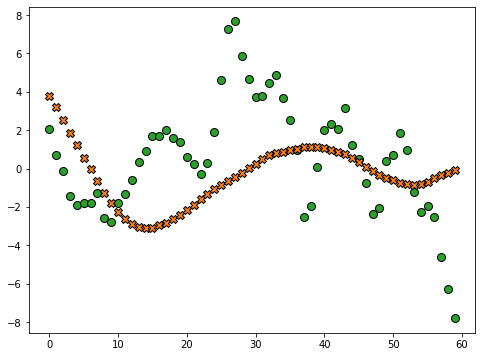

label.shape : (60,)
pred.shape : (60,)


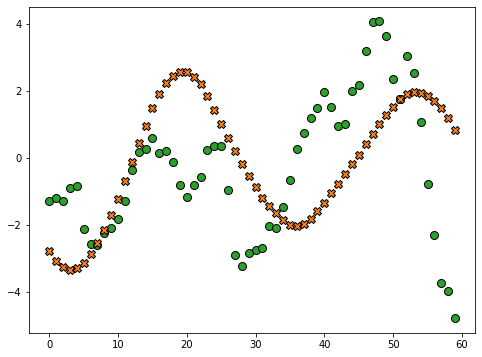

label.shape : (60,)
pred.shape : (60,)


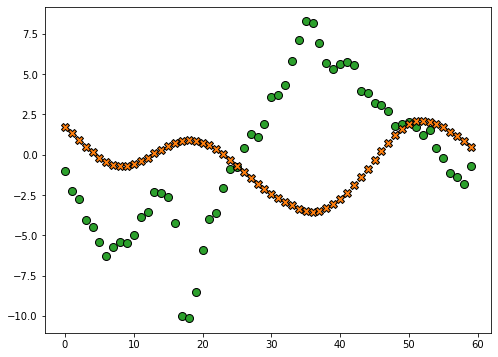

label.shape : (60,)
pred.shape : (60,)


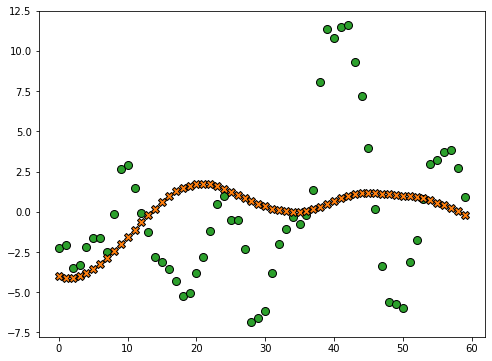

label.shape : (60,)
pred.shape : (60,)


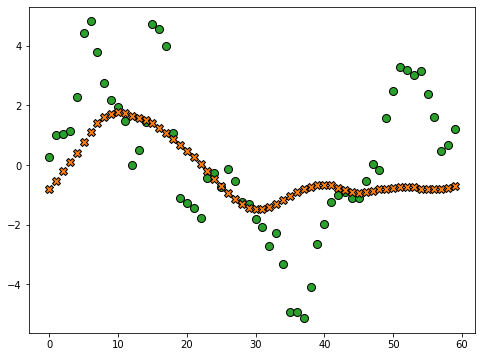

label.shape : (60,)
pred.shape : (60,)


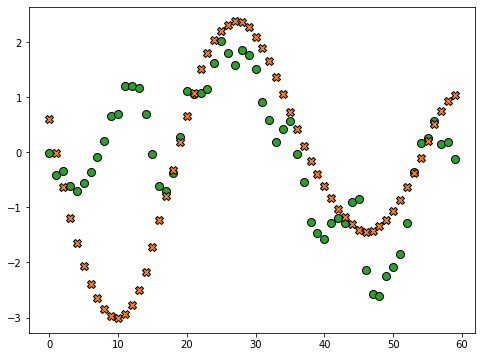

label.shape : (60,)
pred.shape : (60,)


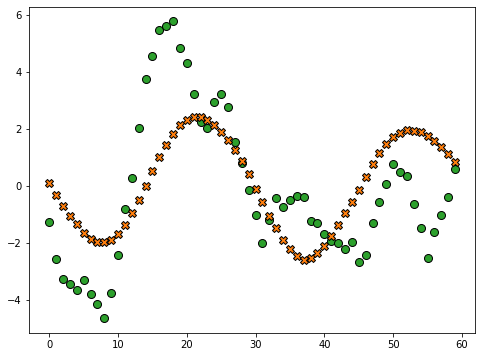

label.shape : (60,)
pred.shape : (60,)


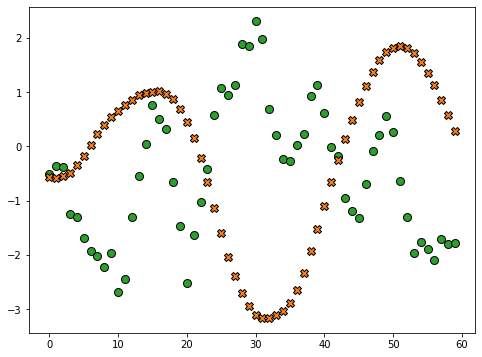

label.shape : (60,)
pred.shape : (60,)


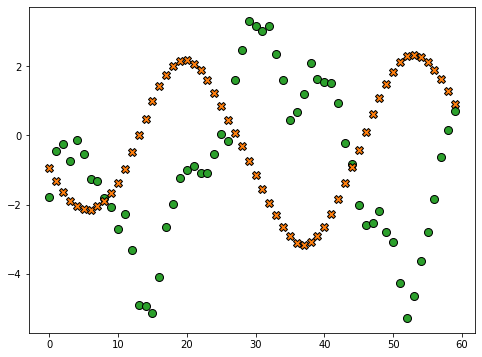

label.shape : (60,)
pred.shape : (60,)


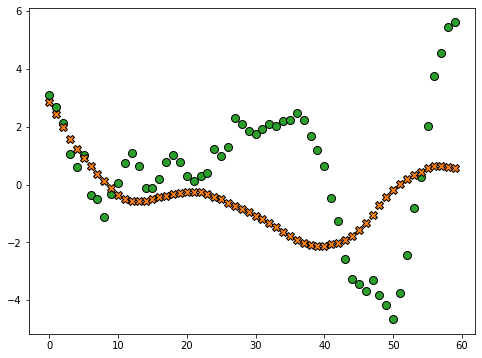

label.shape : (60,)
pred.shape : (60,)


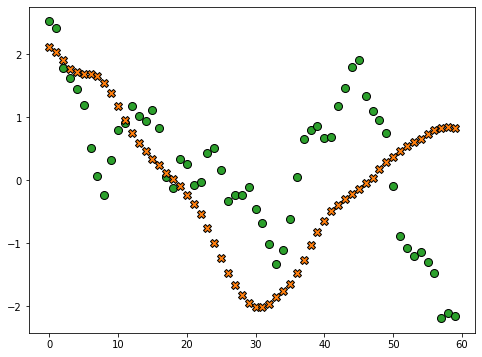

label.shape : (60,)
pred.shape : (60,)


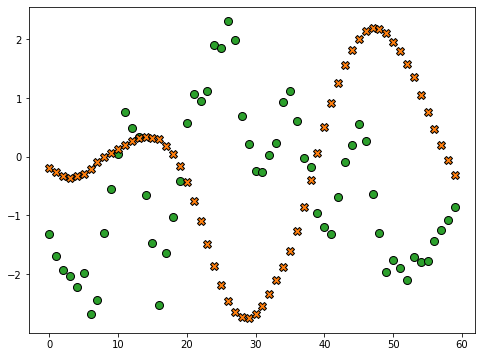

label.shape : (60,)
pred.shape : (60,)


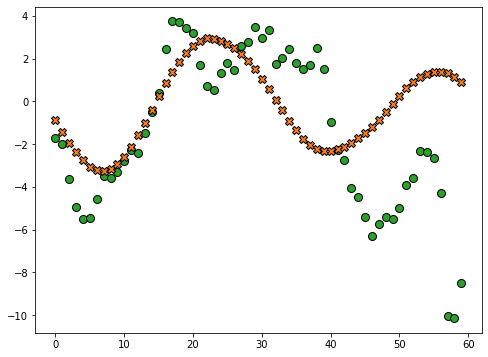

label.shape : (60,)
pred.shape : (60,)


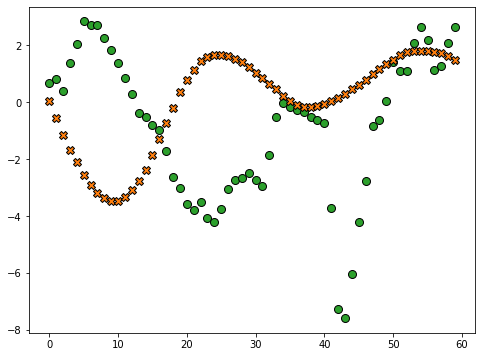

label.shape : (60,)
pred.shape : (60,)


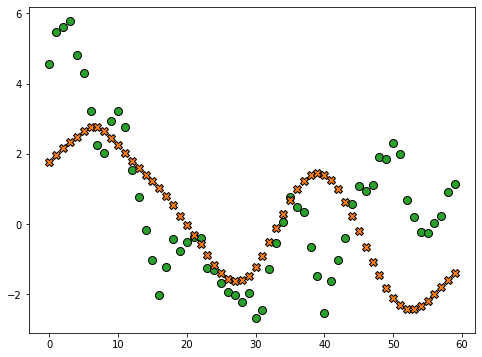

label.shape : (60,)
pred.shape : (60,)


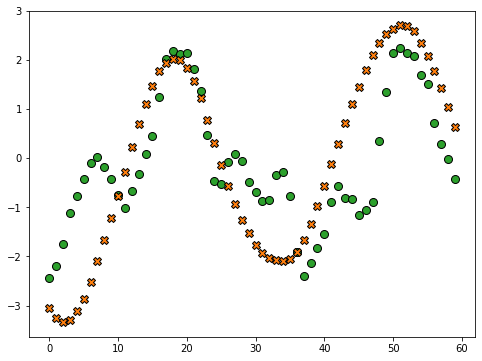

label.shape : (60,)
pred.shape : (60,)


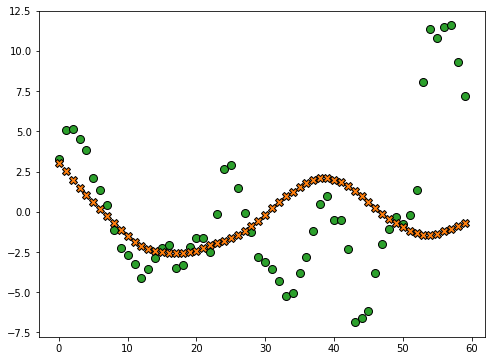

label.shape : (60,)
pred.shape : (60,)


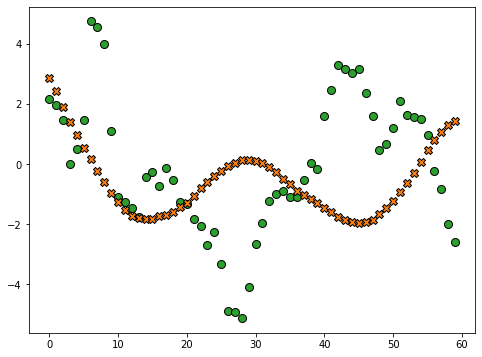

label.shape : (60,)
pred.shape : (60,)


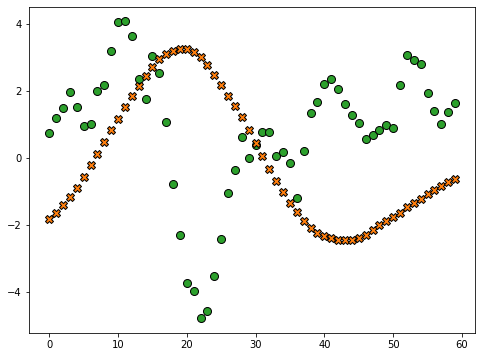

label.shape : (60,)
pred.shape : (60,)


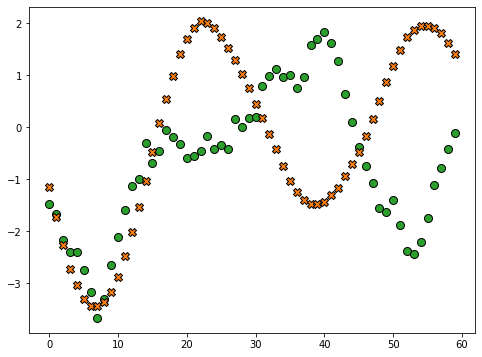

label.shape : (60,)
pred.shape : (60,)


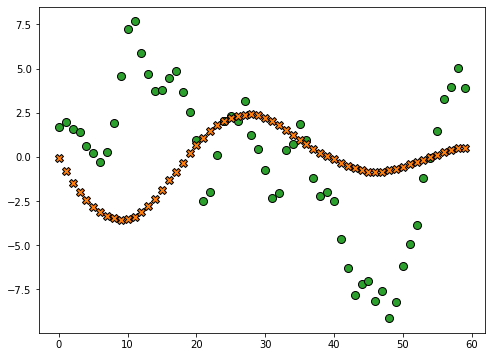

label.shape : (60,)
pred.shape : (60,)


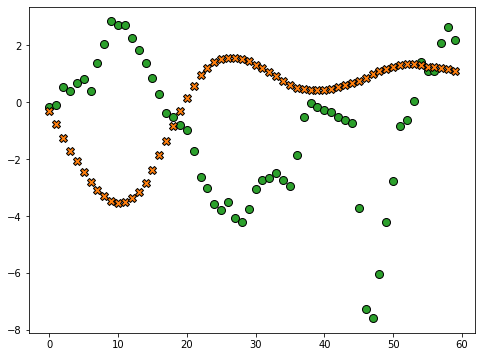

label.shape : (60,)
pred.shape : (60,)


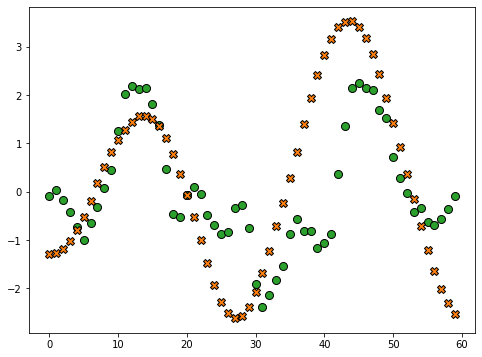

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


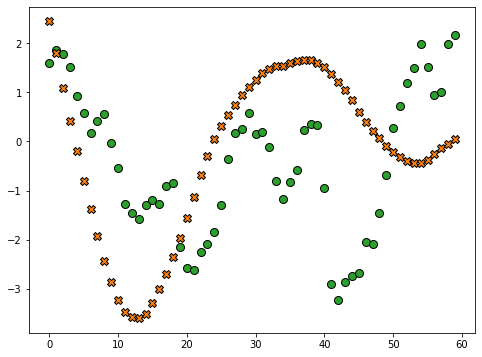

label.shape : (60,)
pred.shape : (60,)


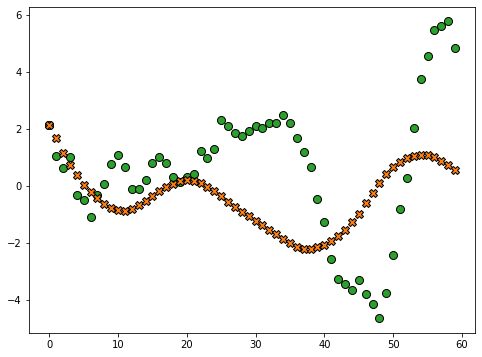

label.shape : (60,)
pred.shape : (60,)


KeyboardInterrupt: ignored

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_lstm_model(x).shape :", multi_lstm_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_lstm_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

#### cnn

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_conv_model)

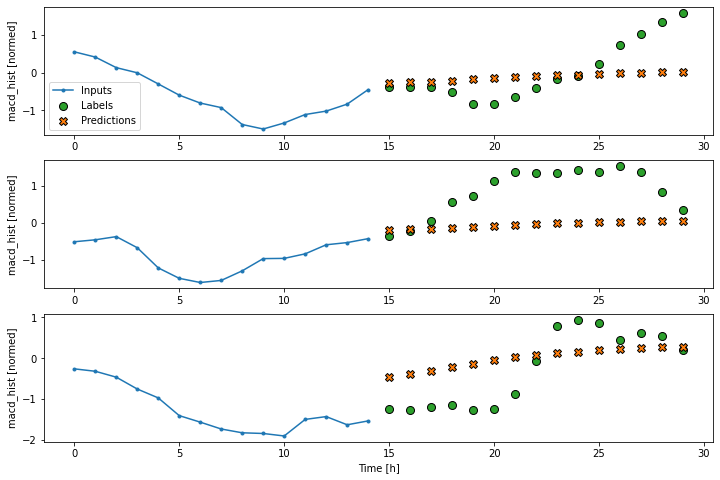

In [ ]:
multi_window.plot(multi_conv_model, max_subplots=3)

##### denorm

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


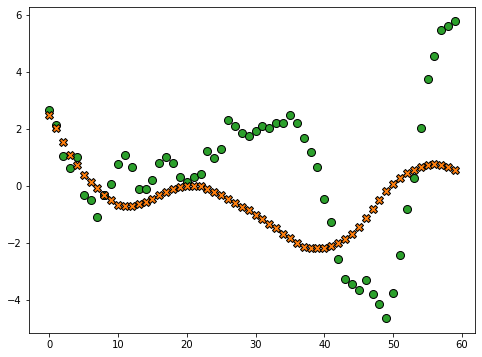

label.shape : (60,)
pred.shape : (60,)


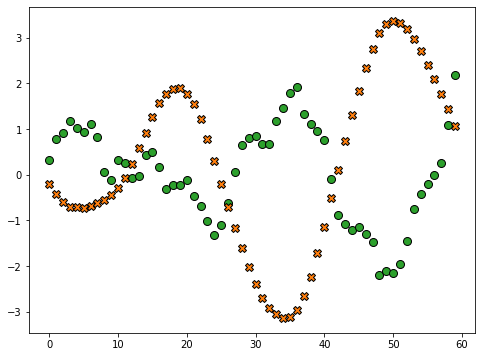

label.shape : (60,)
pred.shape : (60,)


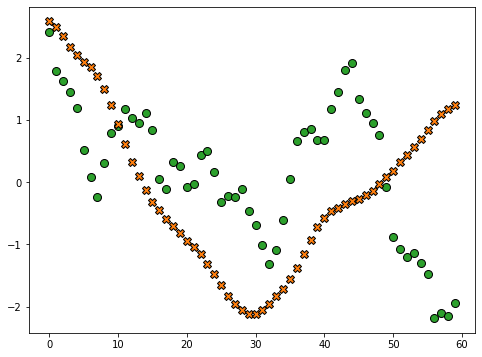

label.shape : (60,)
pred.shape : (60,)


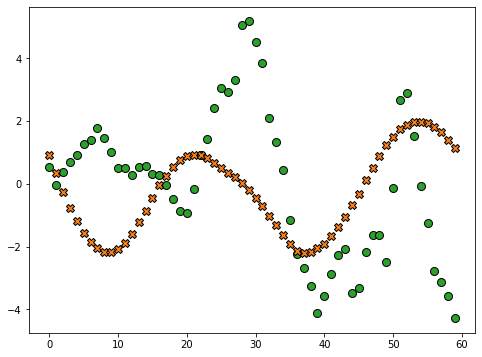

label.shape : (60,)
pred.shape : (60,)


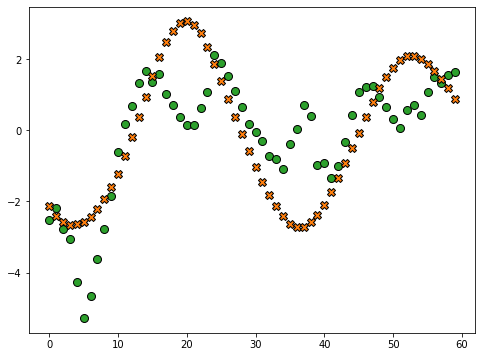

label.shape : (60,)
pred.shape : (60,)


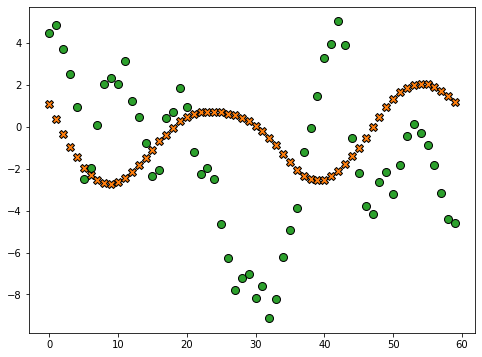

label.shape : (60,)
pred.shape : (60,)


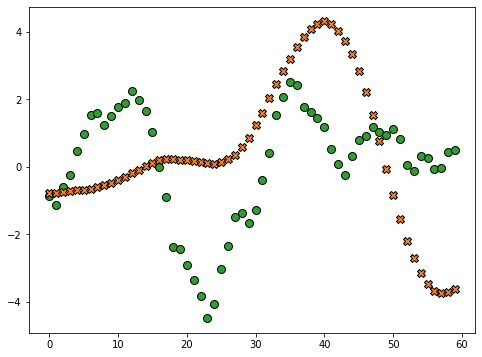

label.shape : (60,)
pred.shape : (60,)


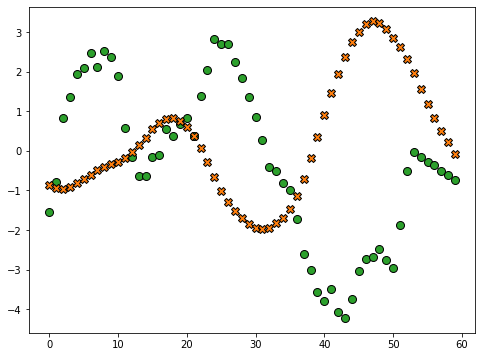

label.shape : (60,)
pred.shape : (60,)


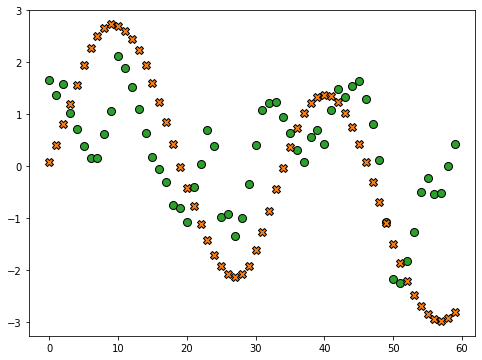

label.shape : (60,)
pred.shape : (60,)


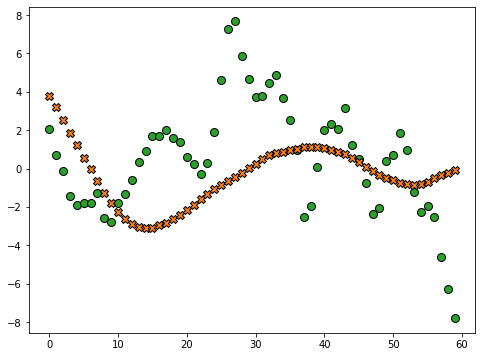

label.shape : (60,)
pred.shape : (60,)


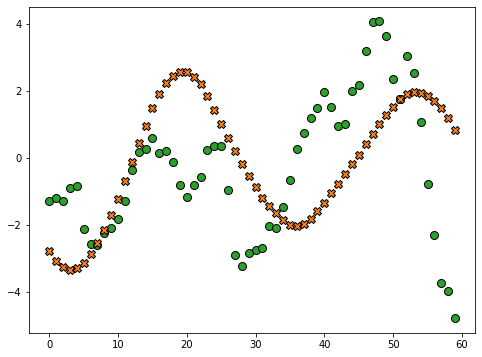

label.shape : (60,)
pred.shape : (60,)


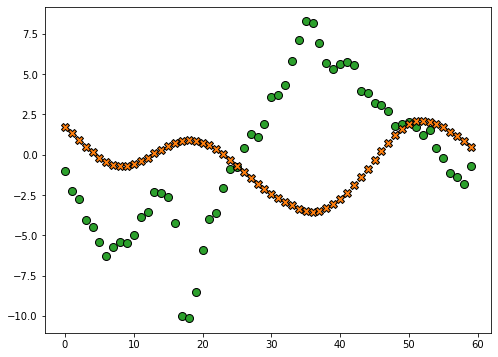

label.shape : (60,)
pred.shape : (60,)


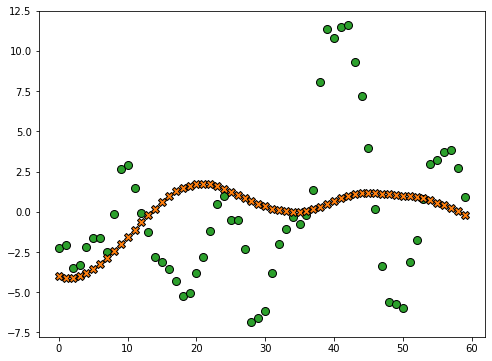

label.shape : (60,)
pred.shape : (60,)


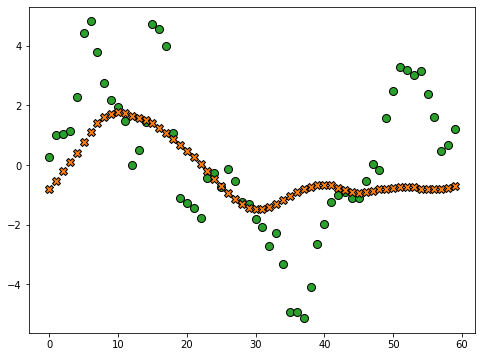

label.shape : (60,)
pred.shape : (60,)


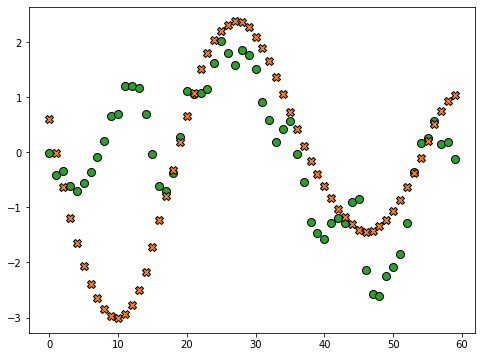

label.shape : (60,)
pred.shape : (60,)


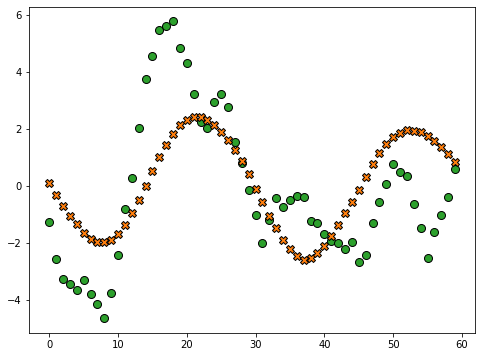

label.shape : (60,)
pred.shape : (60,)


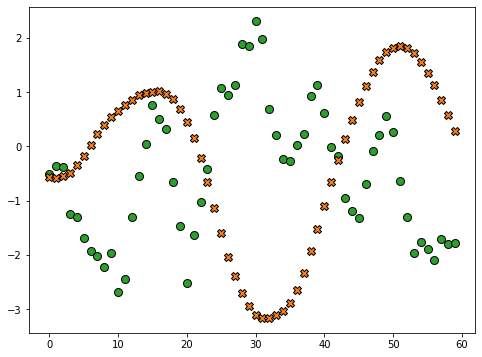

label.shape : (60,)
pred.shape : (60,)


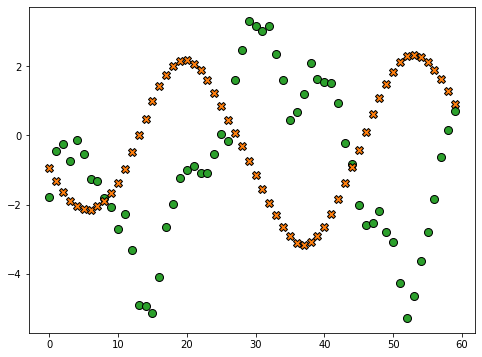

label.shape : (60,)
pred.shape : (60,)


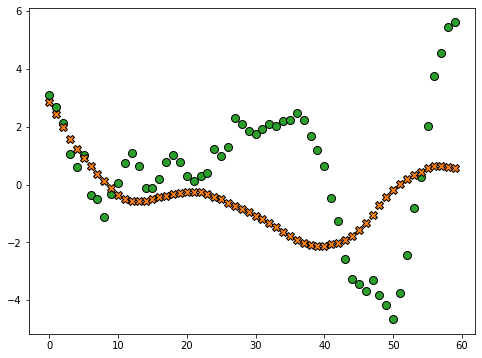

label.shape : (60,)
pred.shape : (60,)


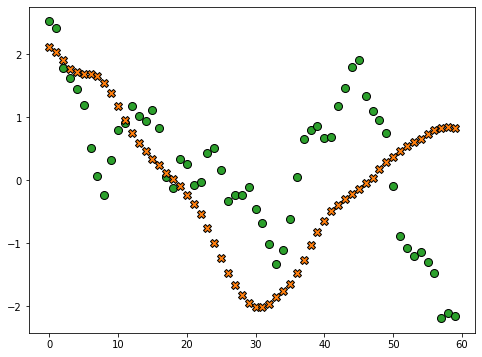

label.shape : (60,)
pred.shape : (60,)


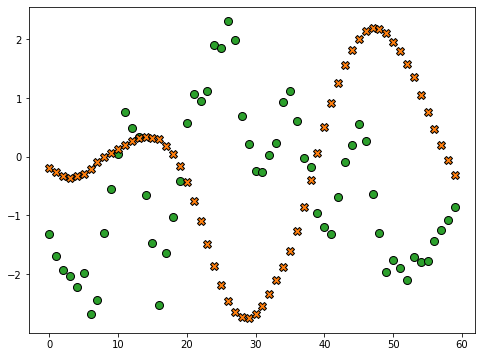

label.shape : (60,)
pred.shape : (60,)


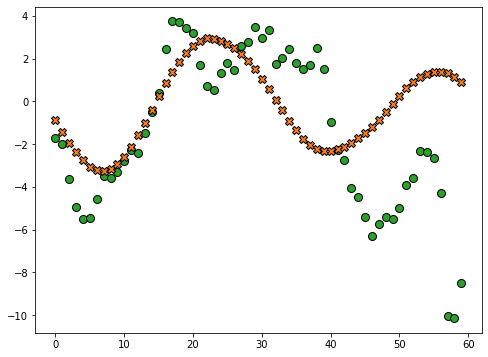

label.shape : (60,)
pred.shape : (60,)


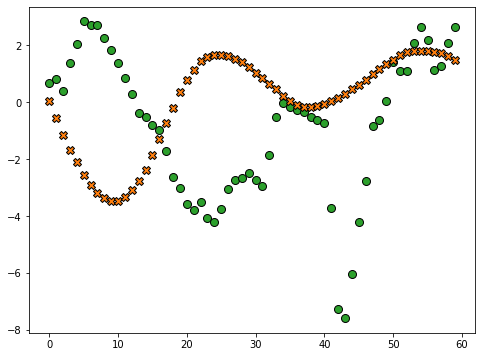

label.shape : (60,)
pred.shape : (60,)


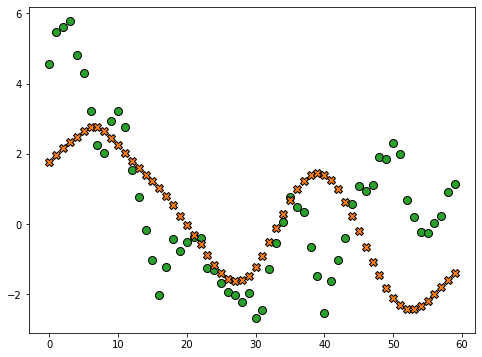

label.shape : (60,)
pred.shape : (60,)


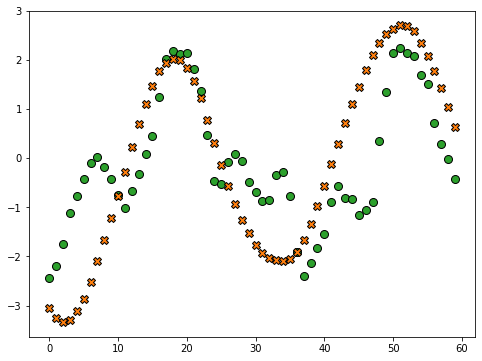

label.shape : (60,)
pred.shape : (60,)


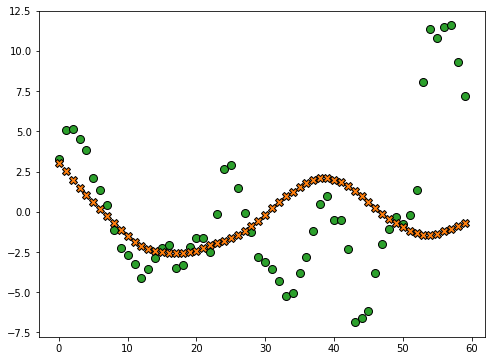

label.shape : (60,)
pred.shape : (60,)


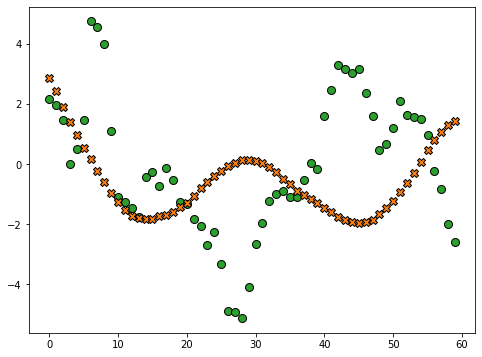

label.shape : (60,)
pred.shape : (60,)


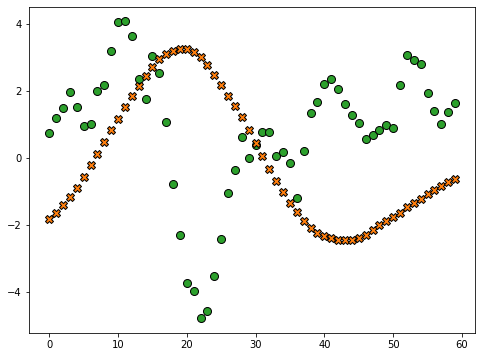

label.shape : (60,)
pred.shape : (60,)


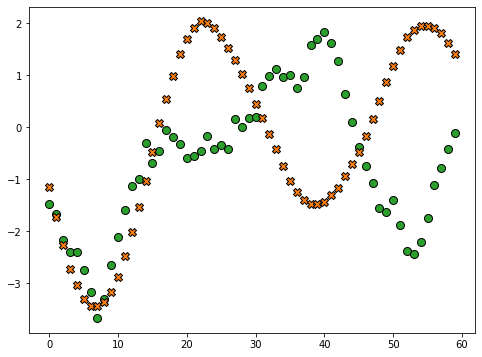

label.shape : (60,)
pred.shape : (60,)


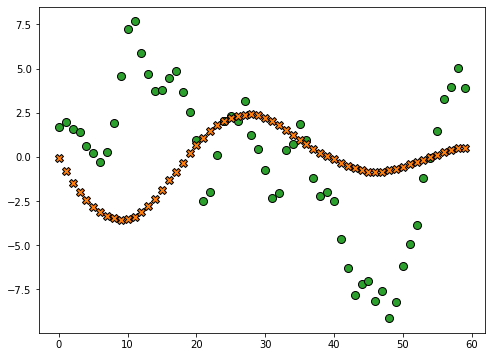

label.shape : (60,)
pred.shape : (60,)


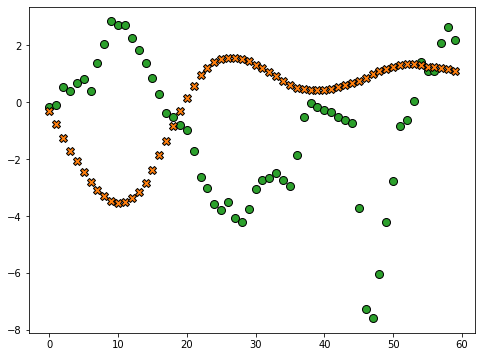

label.shape : (60,)
pred.shape : (60,)


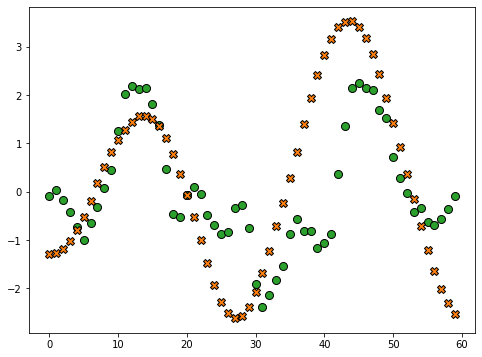

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


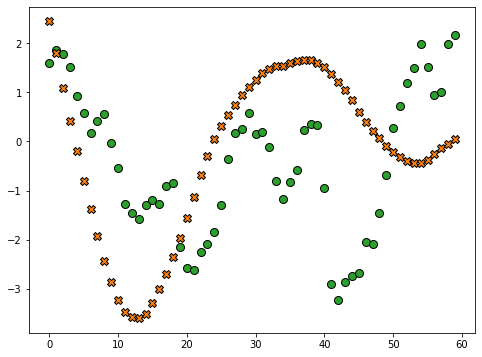

label.shape : (60,)
pred.shape : (60,)


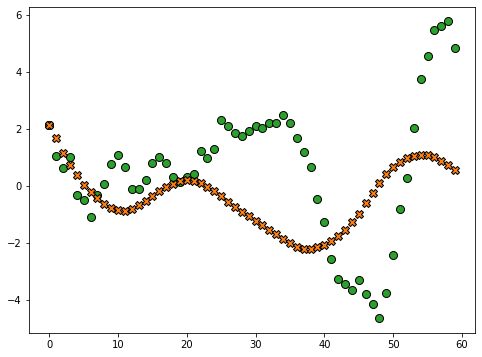

label.shape : (60,)
pred.shape : (60,)


KeyboardInterrupt: ignored

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_lstm_model(x).shape :", multi_lstm_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_lstm_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

#### autoregressive

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 60, 12)


77/77 [==============================] - 1s 13ms/step - loss: 8.8601 - mean_absolute_error: 2.2732


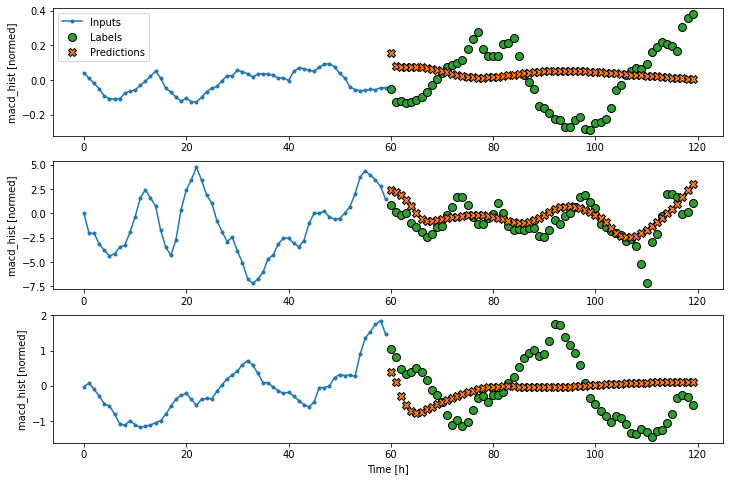

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

##### denorm

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


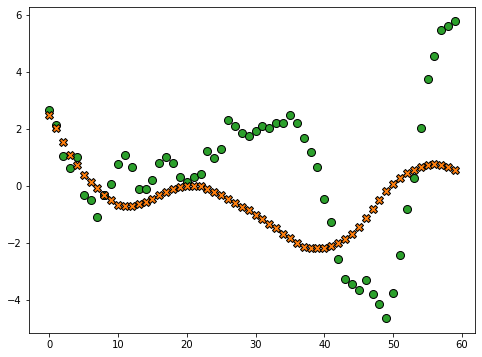

label.shape : (60,)
pred.shape : (60,)


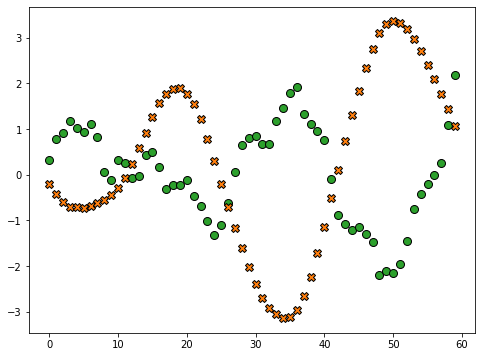

label.shape : (60,)
pred.shape : (60,)


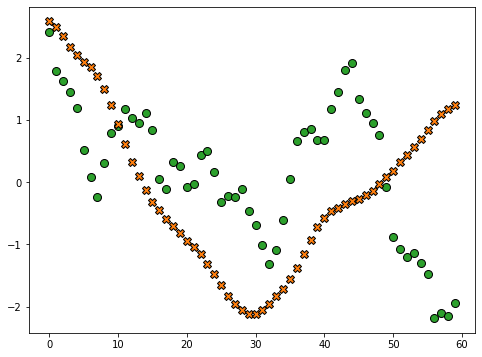

label.shape : (60,)
pred.shape : (60,)


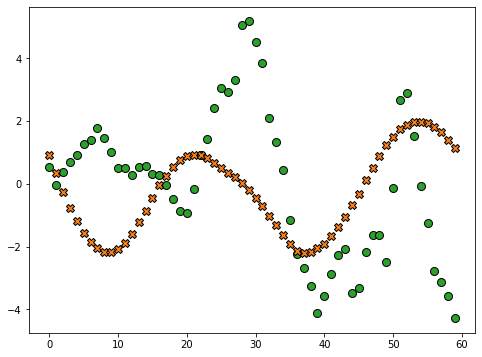

label.shape : (60,)
pred.shape : (60,)


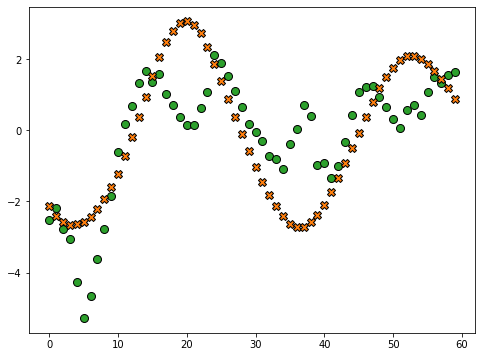

label.shape : (60,)
pred.shape : (60,)


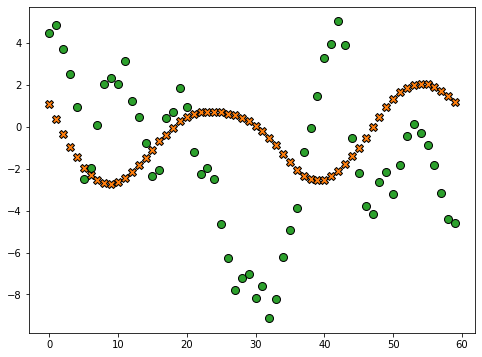

label.shape : (60,)
pred.shape : (60,)


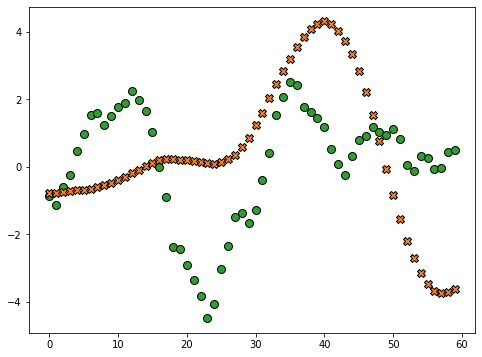

label.shape : (60,)
pred.shape : (60,)


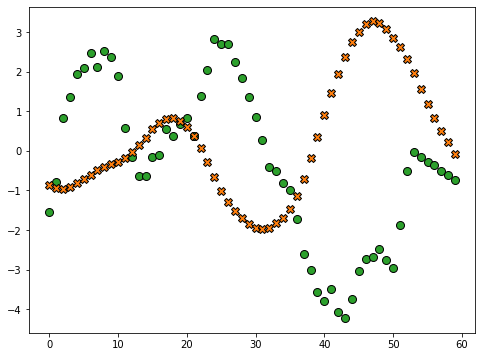

label.shape : (60,)
pred.shape : (60,)


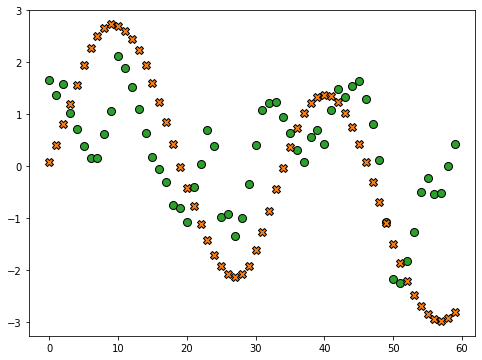

label.shape : (60,)
pred.shape : (60,)


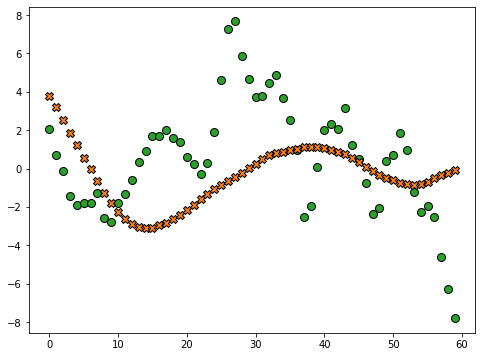

label.shape : (60,)
pred.shape : (60,)


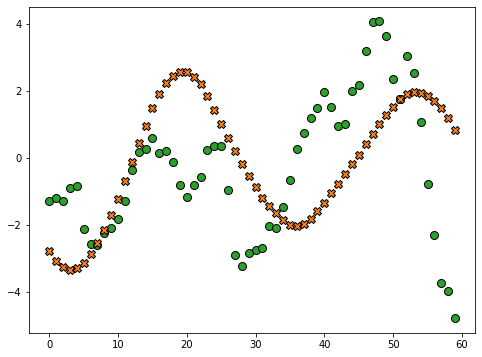

label.shape : (60,)
pred.shape : (60,)


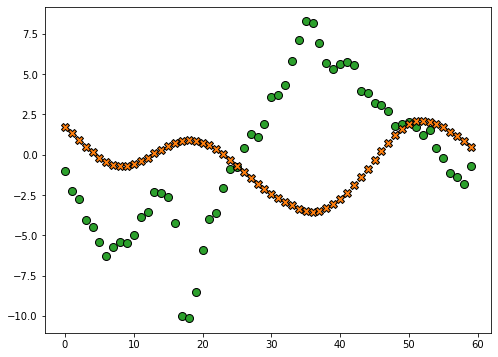

label.shape : (60,)
pred.shape : (60,)


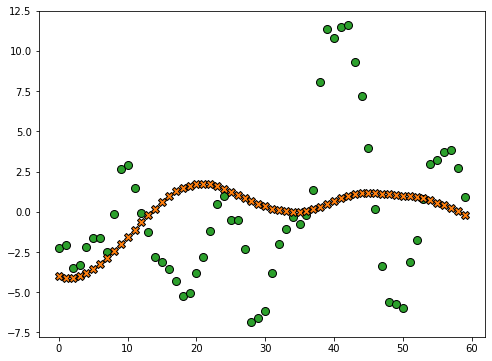

label.shape : (60,)
pred.shape : (60,)


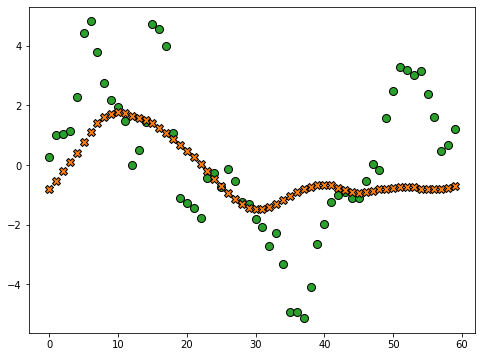

label.shape : (60,)
pred.shape : (60,)


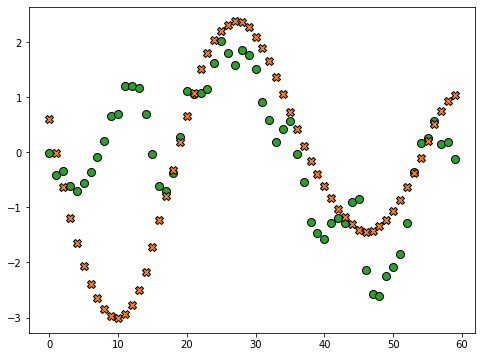

label.shape : (60,)
pred.shape : (60,)


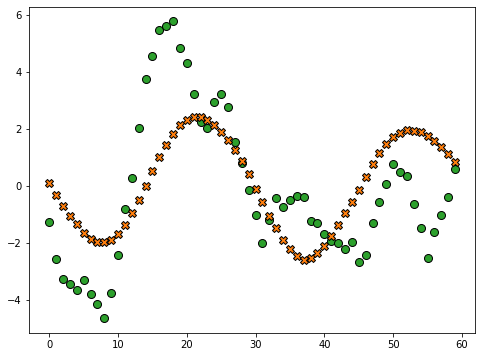

label.shape : (60,)
pred.shape : (60,)


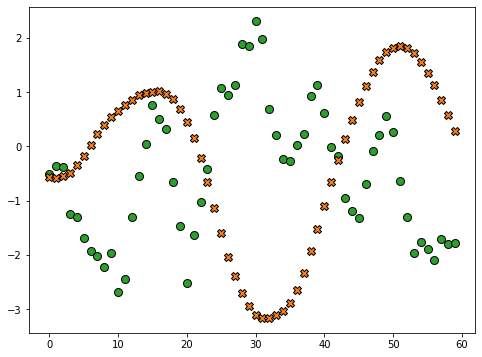

label.shape : (60,)
pred.shape : (60,)


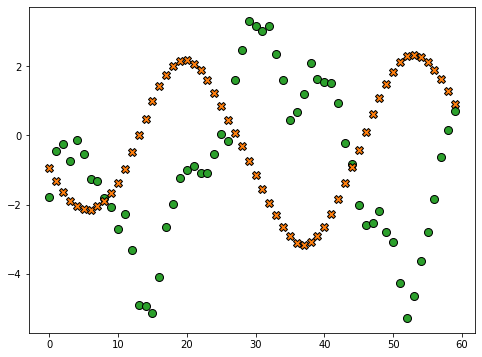

label.shape : (60,)
pred.shape : (60,)


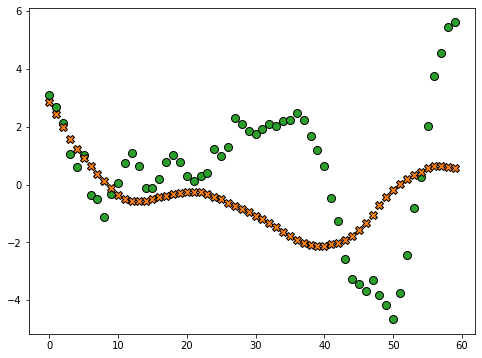

label.shape : (60,)
pred.shape : (60,)


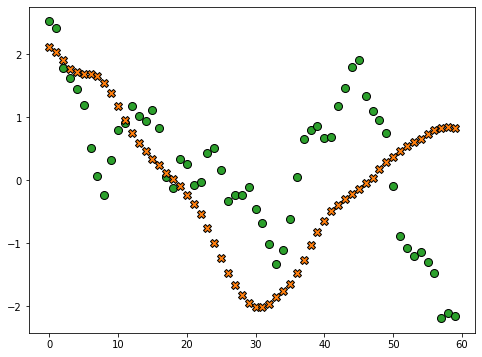

label.shape : (60,)
pred.shape : (60,)


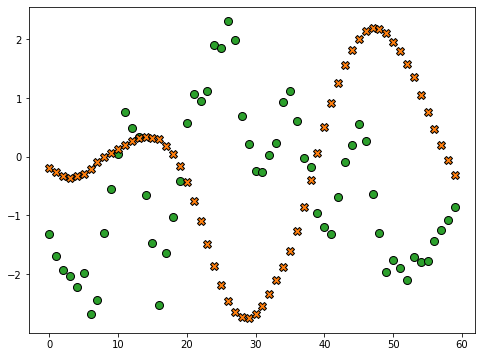

label.shape : (60,)
pred.shape : (60,)


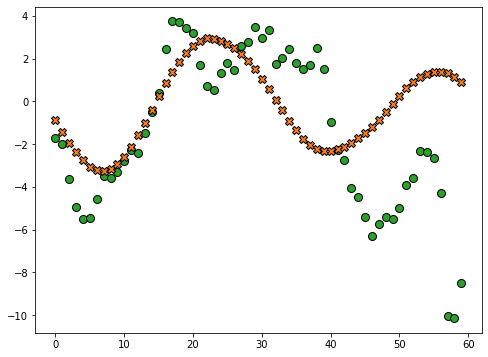

label.shape : (60,)
pred.shape : (60,)


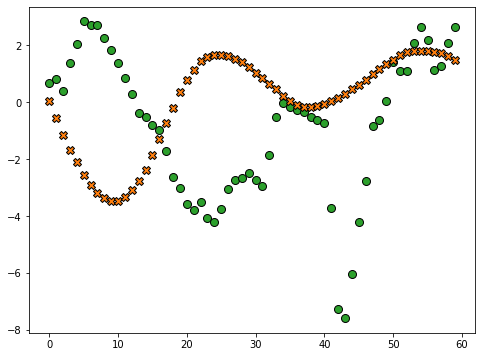

label.shape : (60,)
pred.shape : (60,)


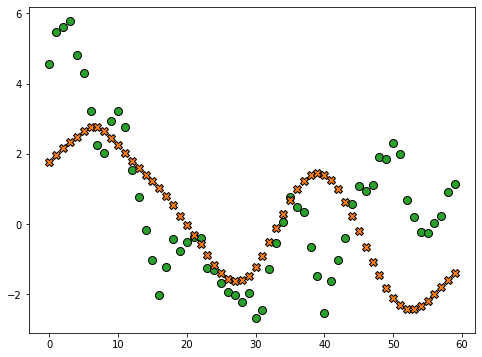

label.shape : (60,)
pred.shape : (60,)


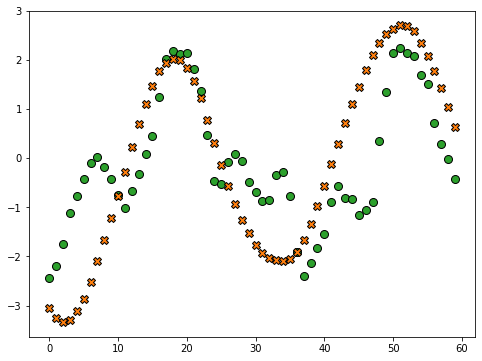

label.shape : (60,)
pred.shape : (60,)


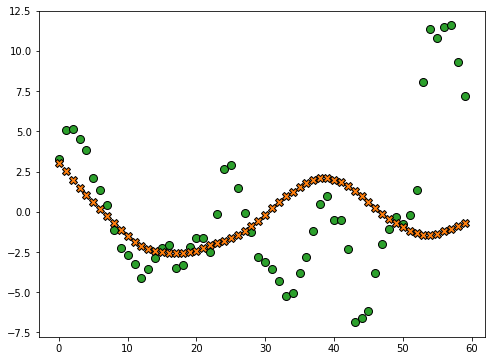

label.shape : (60,)
pred.shape : (60,)


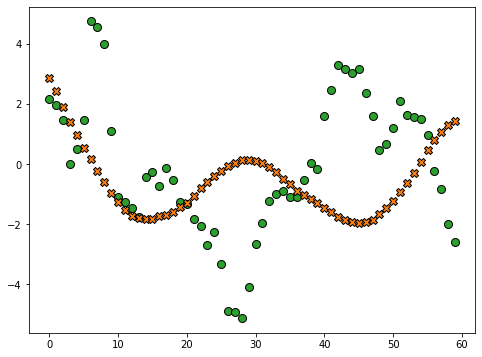

label.shape : (60,)
pred.shape : (60,)


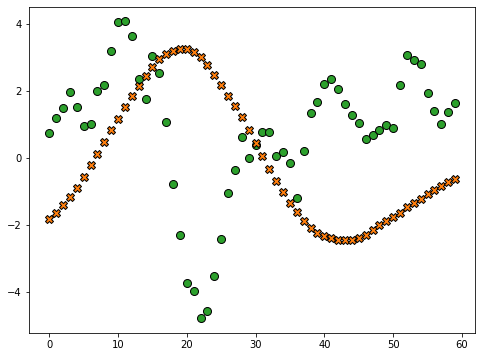

label.shape : (60,)
pred.shape : (60,)


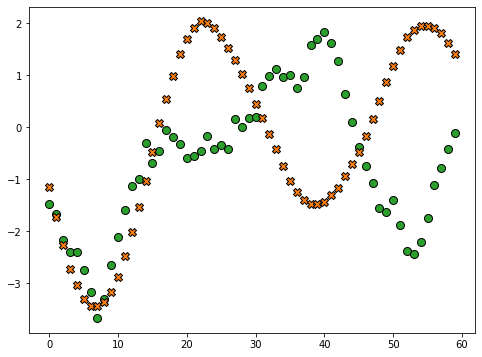

label.shape : (60,)
pred.shape : (60,)


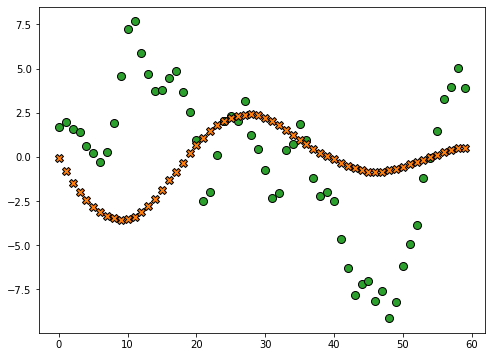

label.shape : (60,)
pred.shape : (60,)


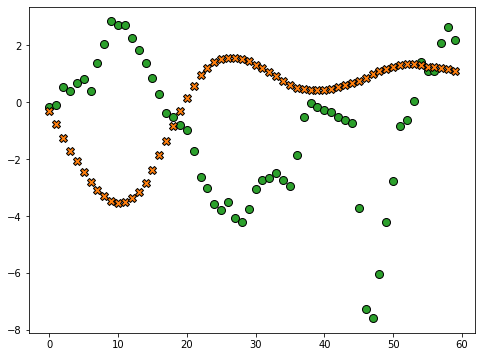

label.shape : (60,)
pred.shape : (60,)


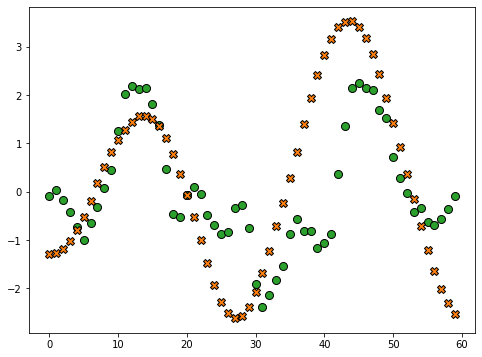

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


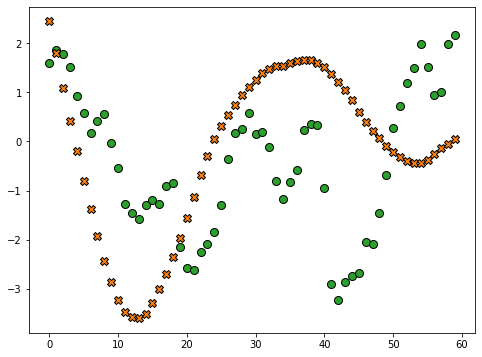

label.shape : (60,)
pred.shape : (60,)


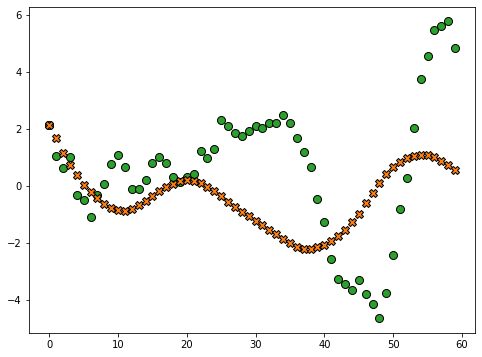

label.shape : (60,)
pred.shape : (60,)


KeyboardInterrupt: ignored

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_lstm_model(x).shape :", multi_lstm_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_lstm_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

#### comparison

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 1.8391
LSTM    : 1.9033
Conv    : 1.8230
AR LSTM : 2.3262
